# Train a cellpose to segment A549 cells  
Author: Ke  
Data source: Dr. Weikang Wang

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
from pathlib import Path

# model_type='cyto' or 'nuclei' or 'cyto2'
model = models.Cellpose(gpu=True, model_type="cyto2")
type(model)

cellpose.models.Cellpose

In [2]:
# path for saving re-fitted cellpose model
model_save_path = Path("./notebook_results/cellpose/cellpose_A549_cyto2_cellbody_bg_corrected")


## Loading data for training models from CellPose

In [3]:
data_dirs = [
    "../datasets/wwk_train/A549_cellbody_seg_train/label/train",
    # "../datasets/wwk_train/A549_seg_train/train",
]
raw_img_dir = [Path(path) / "Img" for path in data_dirs]
dist_img_dir = [Path(path) / "Bwdist" for path in data_dirs]
mask_img_dir = [Path(path) / "Interior" for path in data_dirs]

# check if paths exist
for i in range(len(raw_img_dir)):
    assert raw_img_dir[i].exists(), f"{raw_img_dir[i]} does not exist"
    assert dist_img_dir[i].exists(), f"{dist_img_dir[i]} does not exist"
    assert mask_img_dir[i].exists(), f"{mask_img_dir[i]} does not exist"

In [4]:
raw_img_dir

[PosixPath('../datasets/wwk_train/A549_cellbody_seg_train/label/train/Img')]

In [5]:
raw_img_paths = [sorted(list(path.glob("*.tif"))) for path in raw_img_dir]
dist_img_paths = [sorted(list(path.glob("*.tif"))) for path in dist_img_dir]
mask_img_paths = [sorted(list(path.glob("*.png"))) for path in mask_img_dir]

# check existence of all images
for i in range(len(raw_img_dir)):
    assert len(raw_img_paths[i]) == len(dist_img_paths[i]) == len(
        mask_img_paths[i]
    ), f"Number of images in {raw_img_dir[i]}, {dist_img_dir[i]}, {mask_img_dir[i]} do not match, number of images: {len(raw_img_paths[i])}, {len(dist_img_paths[i])}, {len(mask_img_paths[i])}"

# flatten all lists
raw_img_paths = [item for sublist in raw_img_paths for item in sublist]
dist_img_paths = [item for sublist in dist_img_paths for item in sublist]
mask_img_paths = [item for sublist in mask_img_paths for item in sublist]
    

In [6]:
# read images
raw_imgs = [imread(str(path)) for path in raw_img_paths]
dist_imgs = [imread(str(path)) for path in dist_img_paths]
mask_imgs = [imread(str(path)) for path in mask_img_paths]

In [7]:
len(raw_imgs), len(dist_imgs), len(mask_imgs)

(968, 968, 968)

In [8]:
# squeeze images
raw_imgs = [img.squeeze() for img in raw_imgs]
dist_imgs = [img.squeeze() for img in dist_imgs]
mask_imgs = [img.squeeze() for img in mask_imgs]


### Check image shape match

In [9]:
for i in range(len(raw_imgs)):
    assert (
        raw_imgs[i].shape == dist_imgs[i].shape == mask_imgs[i].shape
    ), f"Image shapes do not match for image {i}, {raw_imgs[i].shape}, {dist_imgs[i].shape}, {mask_imgs[i].shape}"

In [10]:
len(raw_imgs), len(dist_imgs), len(mask_imgs)

(968, 968, 968)

Note the following assumptions  
    when Dr. WWK annotated datasets, he intentionally avoid overlapping masks, so we can obtain label masks simply by label()

In [11]:
from livecell_tracker.preprocess.utils import normalize_img_to_uint8, standard_preprocess
# normalize images
raw_imgs = [standard_preprocess(img) for img in raw_imgs]

In [12]:
import skimage
label_mask_imgs = [skimage.measure.label(mask_img) for mask_img in mask_imgs]

# counter how many mask labels are empty
empty_mask_label_count = 0
for i in range(len(label_mask_imgs)):
    if len(np.unique(label_mask_imgs[i])) <= 1:
        empty_mask_label_count += 1
        # show image and label mask
        # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        # ax[0].imshow(raw_imgs[i])
        # ax[1].imshow(label_mask_imgs[i])
print(f"Number of empty mask labels: {empty_mask_label_count}", "total number of images:", len(label_mask_imgs))

Number of empty mask labels: 0 total number of images: 968


In [13]:
model.sz.cp.train(train_data=raw_imgs, train_labels=label_mask_imgs, batch_size=4, channels=[0,0], n_epochs=1000, save_path=model_save_path)

100%|██████████| 968/968 [00:49<00:00, 19.53it/s]
577 train images with number of masks less than min_train_masks (5), removing from train set


'notebook_results/cellpose/cellpose_A549_cyto2_cellbody_bg_corrected/models/cellpose_residual_on_style_on_concatenation_off_cellpose_A549_cyto2_cellbody_bg_corrected_2023_04_19_13_49_36.030617'

Randomly show 10 prediction samples

masks shape:  (320, 320)


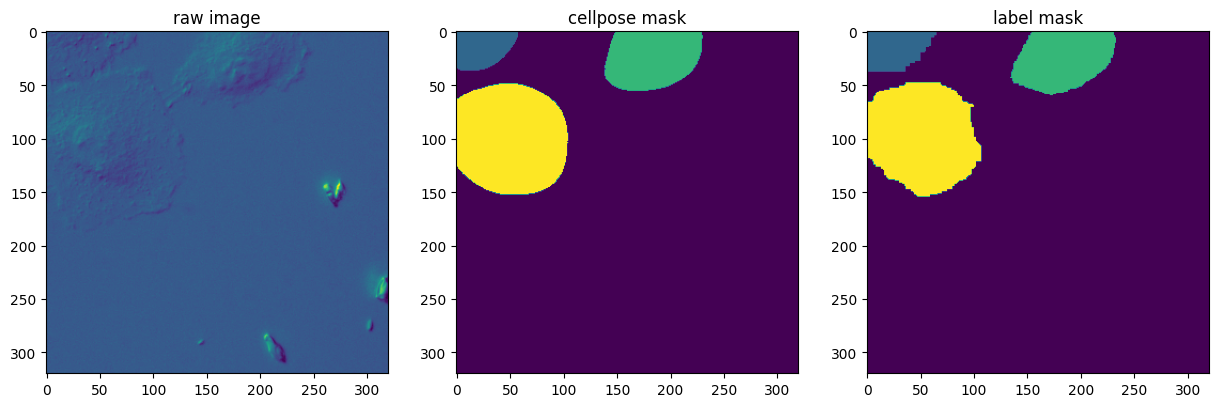

masks shape:  (320, 320)


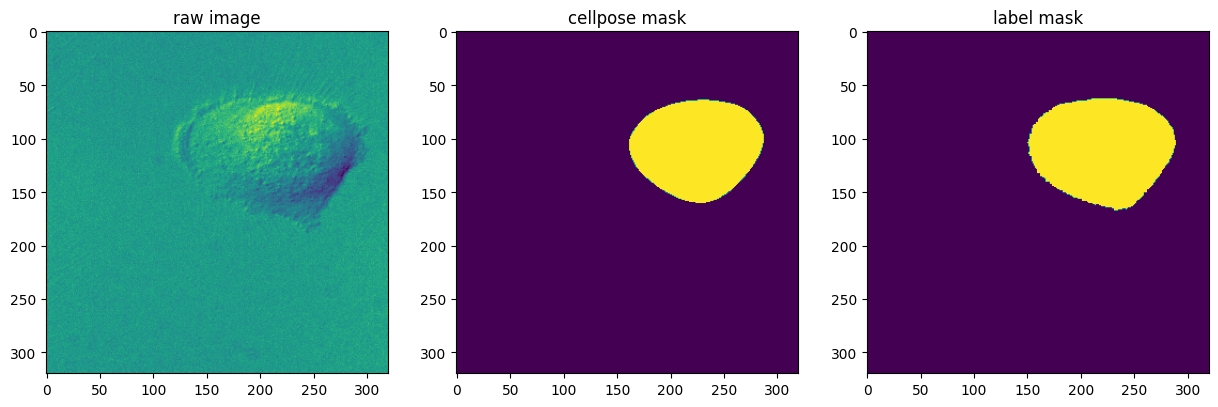

masks shape:  (320, 320)


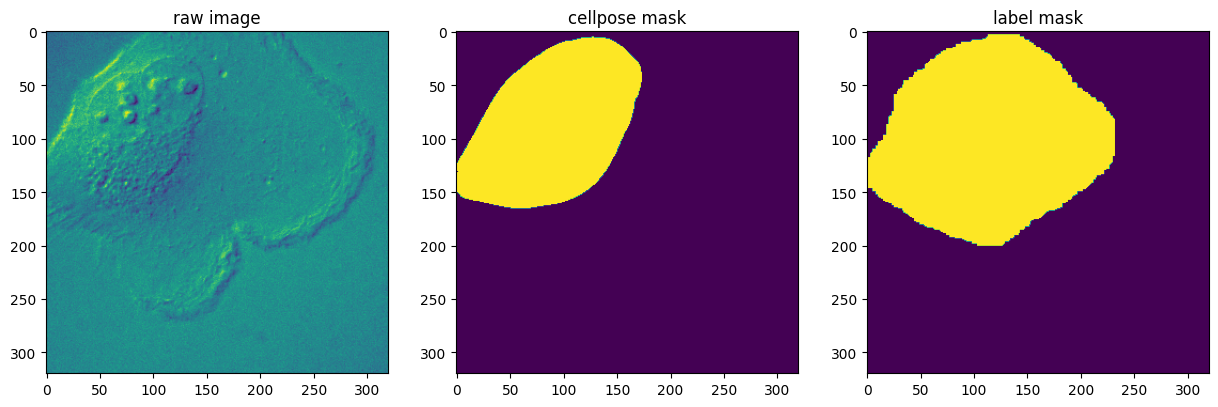

In [14]:
from livecell_tracker.segment.cellpose_utils import segment_single_images_by_cellpose

for _ in range(3):
    index = np.random.randint(0, len(raw_imgs))
    masks = segment_single_images_by_cellpose(raw_imgs[index], model, channels=[[0, 0]], diameter=100)
    print("masks shape: ", masks.shape)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(raw_imgs[index][0])
    axes[0].set_title("raw image")
    axes[1].imshow(masks)
    axes[1].set_title("cellpose mask")
    axes[2].imshow(label_mask_imgs[index])
    axes[2].set_title("label mask")
    plt.show()

## Predict with the model trained on your own data

In [15]:
from livecell_tracker.core.datasets import LiveCellImageDataset, SingleImageDataset
dataset_dir_path = Path(
    "../datasets/test_data_STAV-A549/DIC_data"
)

mask_dataset_path = Path("../datasets/test_data_STAV-A549/mask_data")
dic_dataset = LiveCellImageDataset(dataset_dir_path, ext="tif")

3 tif img file paths loaded;


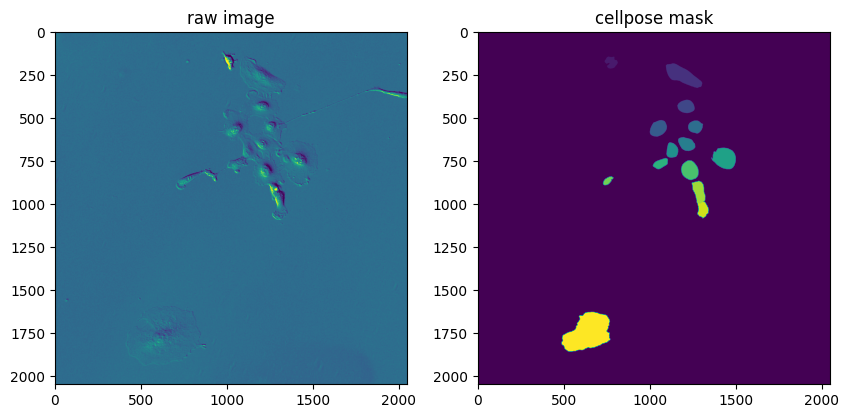

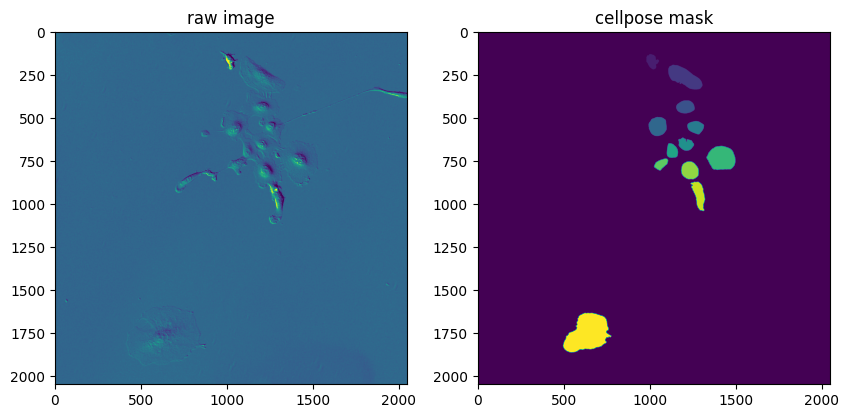

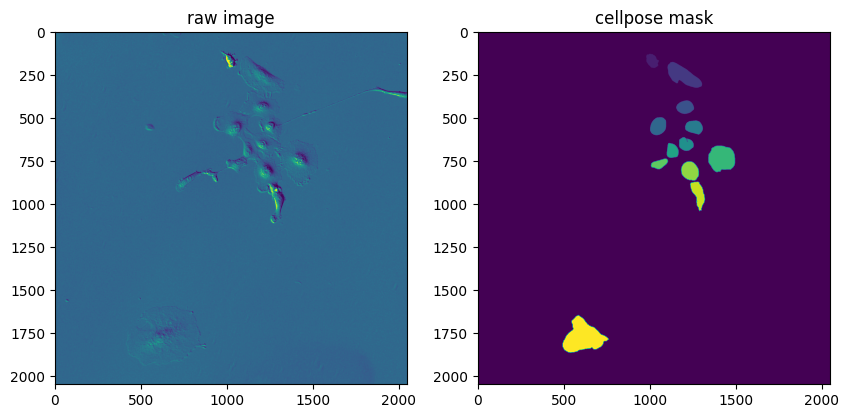

In [16]:
from livecell_tracker.preprocess.utils import enhance_contrast
for i in range(0, len(dic_dataset), 1):
    img = dic_dataset[i]
    # img = normalize_img_to_uint8(img)
    img = standard_preprocess(img)
    masks = segment_single_images_by_cellpose(img, model, channels=[[0, 0]], diameter=80)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(enhance_contrast(img.astype(np.uint8)))
    axes[0].set_title("raw image")
    axes[1].imshow(masks)
    axes[1].set_title("cellpose mask")
    plt.show()

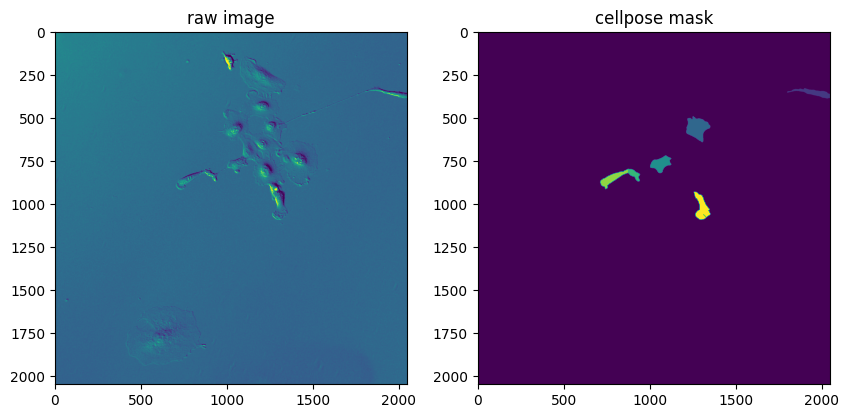

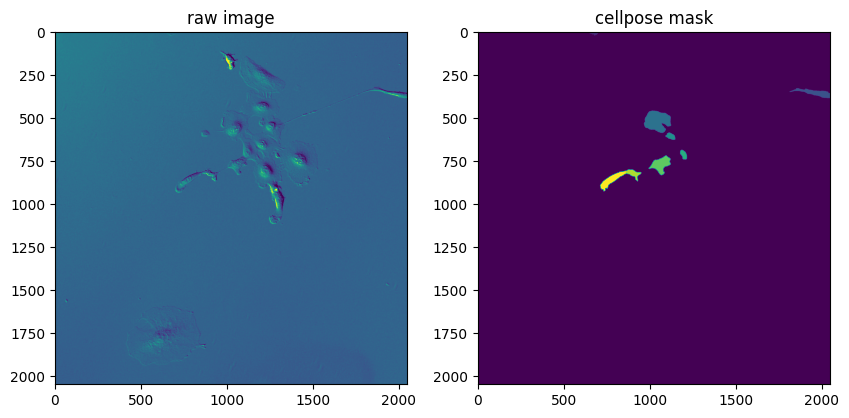

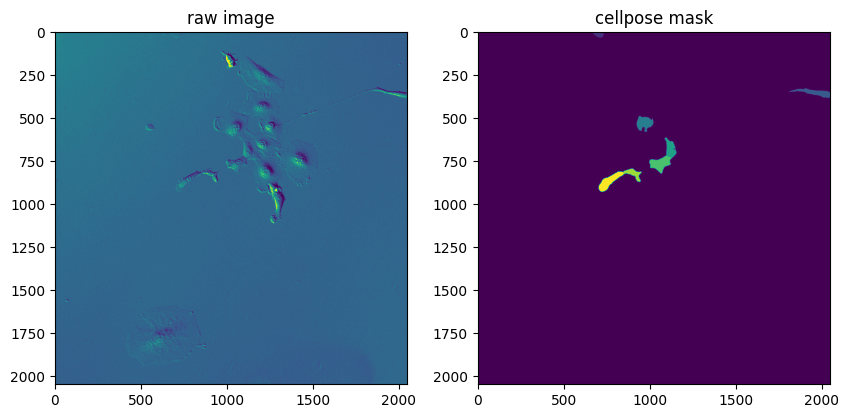

In [17]:
original_pretrained_model = models.Cellpose(gpu=True, model_type="cyto2")
for i in range(0, len(dic_dataset), 1):
    img = dic_dataset[i]
    img = normalize_img_to_uint8(img)
    masks = segment_single_images_by_cellpose(img, original_pretrained_model, channels=[[0, 0]], diameter=80)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(enhance_contrast(img))
    axes[0].set_title("raw image")
    axes[1].imshow(masks)
    axes[1].set_title("cellpose mask")
    plt.show()